In [1]:
import os
import numpy as np
import pandas as pd
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt


In [2]:
def lorentzian_function(x, s0, corner):
    return (s0*corner**2) / (x**2 + corner**2)

In [3]:
def multi_fractal_function(x, beta_low, beta_high, A, B, corner):
    return np.where(x < corner, A * x**beta_low, B * x**beta_high)

In [4]:
# Function to visualize the original time series
def visualize_time_series(time_series, sampling_interval, title="Time Series"):
    # Generate time points based on the sampling interval and length of the series
    time_points = [i * sampling_interval for i in range(len(time_series))]
    
    plt.figure(figsize=(8, 5))
    plt.plot(time_points, time_series, label='Time Series', linewidth=1.5, color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal Intensity')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [5]:
# Function to visualize the Power Spectral Density
def visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density"):
    plt.figure(figsize=(8, 5))
    plt.plot(xdata, ydata, label='PSD', linewidth=1.5, color='blue')
    
    # Add dashed vertical lines at f1 and f2
    # plt.axvline(x=f1, color='red', linestyle='--', label=f'Boundary f1: {f1}')
    # plt.axvline(x=f2, color='green', linestyle='--', label=f'Boundary f2: {f2}')
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [6]:
def visualize_log_psd(xdata, ydata, f1, f2, title="Log-Log Power Spectral Density", xlabel="Log(Frequency)", ylabel="Log(Power)"):
    """
    Visualize the Power Spectral Density (PSD) with log-log transformation.

    Parameters:
    - xdata (numpy array): Frequency values.
    - ydata (numpy array): Power values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    # Apply log transformation
    log_xdata = np.log10(xdata)
    log_ydata = np.log10(ydata)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(log_xdata, log_ydata, label="Log-Log PSD", linewidth=2, color='blue')

    # Add dashed vertical lines at f1 and f2
    # plt.axvline(x=np.log10(f1), color='red', linestyle='--', label=f'Boundary log(f1): {np.log10(f1)}')
    # plt.axvline(x=np.log10(f2), color='green', linestyle='--', label=f'Boundary log(f2): {np.log10(f2)}')

    # Add a dashed gray vertical line at frequencies 0.1 Hz and 0.15 Hz
    plt.axvline(x=np.log10(0.1), color='gray', linestyle='--')
    plt.axvline(x=np.log10(0.15), color='gray', linestyle='--')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


In [7]:
def lowpass_filter(data, highcut, fs, order=4):
    """
    Apply a low-pass filter to the fMRI time-series data.

    Parameters:
    - data (numpy array): Input time-series data (1D).
    - highcut (float): High cutoff frequency in Hz.
    - fs (float): Sampling frequency (1/TR in Hz).
    - order (int): Order of the Butterworth filter.

    Returns:
    - filtered_data (numpy array): Low-pass filtered data.
    """
    if highcut <= 0 or highcut >= 0.5 * fs:
        raise ValueError("High cutoff frequency must lie within the range (0, Nyquist frequency).")

    nyquist = 0.5 * fs  # Nyquist frequency
    print(f"Nyquist frequency equals: {nyquist}")

    high = highcut / nyquist
    b, a = butter(order, high, btype='low')  # Low-pass filter coefficients
    filtered_data = filtfilt(b, a, data)  # Apply the filter
    return filtered_data


In [8]:
def repetition_time(filename):

    site = filename.split('/')[-1].split('_')[-2]

    if 'Amsterdam-AMC' in site:
        TR = 2.375
    elif 'Amsterdam-VUmc' in site:
        TR = 1.8
    elif 'Barcelona-HCPB' in site:
        TR = 2
    elif 'Bergen' in site:
        TR = 1.8
    elif 'Braga-UMinho-Braga-1.5T' in site:
        TR = 2
    elif 'Braga-UMinho-Braga-1.5T-act' in site:
        TR = 2
    elif 'Braga-UMinho-Braga-3T' in site:
        TR = 1
    elif 'Brazil' in site:
        TR = 2
    elif 'Cape-Town-UCT-Allegra' in site:
        TR = 1.6
    elif 'Cape-Town-UCT-Skyra' in site:
        TR = 1.73
    elif 'Chiba-CHB' in site:
        TR = 2.3
    elif 'Chiba-CHBC' in site:
        TR = 2.3 
    elif 'Chiba-CHBSRPB' in site:
        TR = 2.5 
    elif 'Dresden' in site:
        TR = 0.8 
    elif 'Kyoto-KPU-Kyoto1.5T' in site:
        TR = 2.411 
    elif 'Kyoto-KPU-Kyoto3T' in site:
        TR = 2
    elif 'Kyushu' in site:
        TR = 2.5
    elif 'Milan-HSR' in site:
        TR = 2
    elif 'New-York' in site:
        TR = 1
    elif 'NYSPI-Columbia-Adults' in site:
        TR = 0.85
    elif 'NYSPI-Columbia-Pediatric' in site:
        TR = 0.85
    elif 'Yale-Pittinger-HCP-Prisma' in site:
        TR = 0.8
    elif 'Yale-Pittinger-HCP-Trio' in site:
        TR = 0.7
    elif 'Yale-Pittinger-Yale-2014' in site:
        TR = 2
    elif 'Bangalore-NIMHANS' in site:
        TR = 2 
    elif 'Barcelone-Bellvitge-ANTIGA-1.5T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-COMPULSE-3T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-PROV-1.5T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-RESP-CBT-3T' in site:
        TR = 2
    elif 'Seoul-SNU' in site:
        TR = 3.5
    elif 'Shanghai-SMCH' in site:
        TR = 3
    elif 'UCLA' in site:
        TR = 2
    elif 'Vancouver-BCCHR' in site:
        TR = 2
    elif 'Yale-Gruner' in site:
        TR = 2
    else:
        raise ValueError(f"Site '{site}' does not have a defined TR value in TR_mappings. Please add it.")
        
    print(f"Site: {site}")
    
    return TR

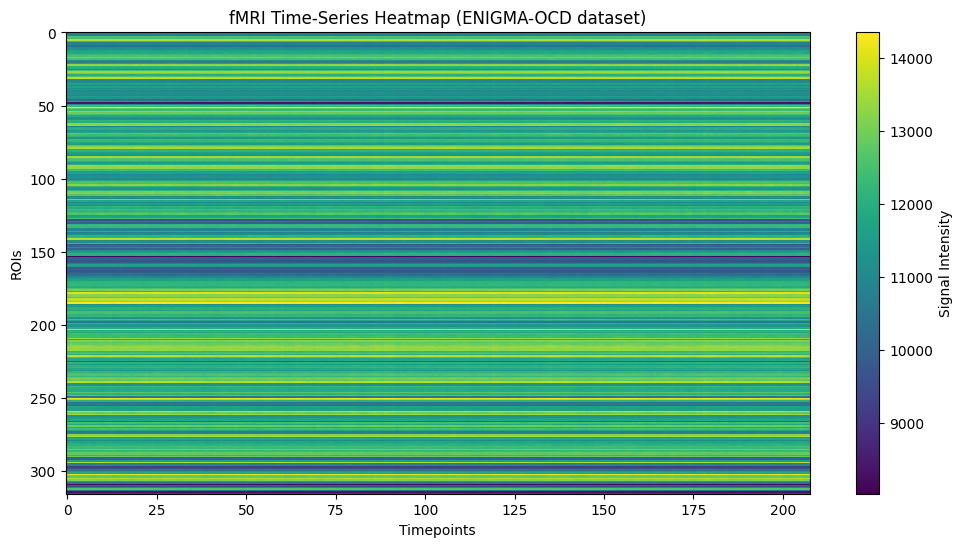

In [9]:
# Example fMRI time-series data (timepoints x ROIs)
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Brazil_sub-P00196820141124/Brazil_sub-P00196820141124.npy")
filename = "Brazil_sub-P00196820141124/Brazil_sub-P00196820141124.npy"
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/UCLA_sub-AOCD051/UCLA_sub-AOCD051.npy")
filename = "UCLA_sub-AOCD051/UCLA_sub-AOCD051.npy"
# time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/NYSPI-Columbia-Pediatric_sub-TYZKNG/NYSPI-Columbia-Pediatric_sub-TYZKNG.npy")
# filename = "NYSPI-Columbia-Pediatric_sub-TYZKNG/NYSPI-Columbia-Pediatric_sub-TYZKNG.npy"
# time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/New-York_sub-subSEQ1NKISENR133/New-York_sub-subSEQ1NKISENR133.npy")
# filename = "New-York_sub-subSEQ1NKISENR133/New-York_sub-subSEQ1NKISENR133.npy"
# time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Chiba-CHBC_sub-HCC010/Chiba-CHBC_sub-HCC010.npy")
# filename = "Chiba-CHBC_sub-HCC010/Chiba-CHBC_sub-HCC010.npy"


# Plot the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(time_series_data.T, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Signal Intensity")
plt.xlabel("Timepoints")
plt.ylabel("ROIs")
plt.title("fMRI Time-Series Heatmap (ENIGMA-OCD dataset)")
plt.show()


In [10]:
y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]
TR = repetition_time(filename)

'''
get knee frequency
'''

sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec   
print(f"sample_whole: {sample_whole}") 

T = TimeSeries(sample_whole, sampling_interval=TR)
print(f"T: {T}")
S_original = SpectralAnalyzer(T)
print(f"S_original: {S_original}")

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
# ydata = np.abs(S_original.spectrum_fourier[1][1:])

# # initial parameter
# p0 = [0, 0.006]

# # fitting Lorentzian function
# popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

# f1 = popt[1]

# knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))
# print(f"knee value: {knee}")

# if knee <= 0:
#     knee = 1

# # initial parameter
# p1 = [2, 1, 23, 25, 0.16]
# # fitting multifractal function
# popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
# pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
# f2 = popt_mo[-1]

# print(f"frequency_range max: {xdata.shape[0]}")
# print(f"knee value: {knee}")
# print(f"f1: {f1}")
# print(f"f2: {f2}")

Site: UCLA
sample_whole: [11855.12096143 11879.55161957 11885.9391893  11869.23878804
 11864.374423   11858.50648388 11874.61661567 11858.12122509
 11860.18079609 11864.71647022 11861.20414758 11861.71565655
 11882.36640373 11855.52576004 11857.92887348 11871.70918858
 11864.68253687 11869.34905741 11856.29850229 11866.72008269
 11883.09323575 11865.29966225 11882.8054319  11854.18781442
 11875.31036179 11864.4022674  11873.42702779 11882.11505574
 11875.88944027 11882.28037491 11872.10917593 11868.13288327
 11872.6823168  11875.03788678 11848.8859911  11853.68429838
 11855.1501714  11861.69220049 11849.46184416 11839.32979648
 11852.94914031 11867.09251234 11848.83748235 11871.42967522
 11871.20445295 11874.51845248 11876.57051414 11895.73187798
 11879.51004766 11855.62461681 11878.39345687 11870.72507267
 11869.78842402 11862.26878737 11852.28854291 11871.96013193
 11871.97691314 11874.86588788 11869.99188758 11859.04095045
 11876.51725077 11843.1401432  11848.77775397 11854.06408431

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [11]:
# visualize PSD
f1 = 0
f2 = 0
visualize_psd(xdata, ydata, f1, f2, title="Unfiltered Data: Power Spectral Density")


NameError: name 'ydata' is not defined

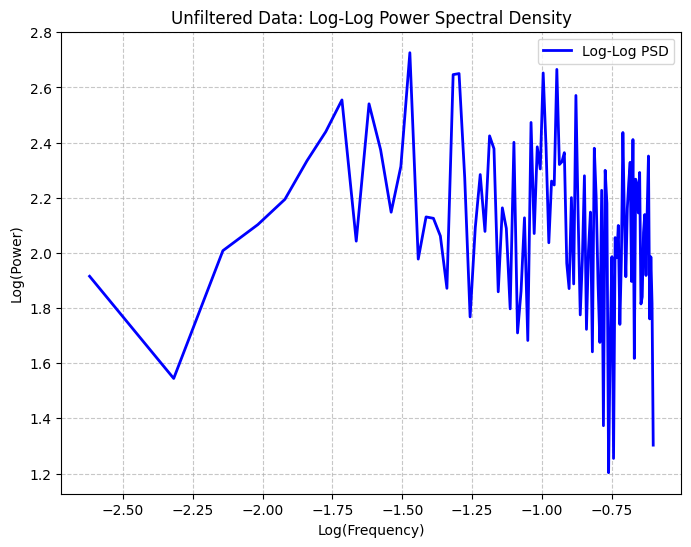

In [96]:
# Apply log transformation
log_xdata = np.log10(xdata)
log_ydata = np.log10(ydata)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(log_xdata, log_ydata, label="Log-Log PSD", linewidth=2, color='blue')

# # Add a dashed gray vertical line at frequencies 0.1 Hz and 0.15 Hz
# plt.axvline(x=np.log10(0.1), color='gray', linestyle='--')
# plt.axvline(x=np.log10(0.15), color='gray', linestyle='--')

plt.title("Unfiltered Data: Log-Log Power Spectral Density")
plt.xlabel("Log(Frequency)")
plt.ylabel("Log(Power)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [112]:
TR = repetition_time(filename) # Repetition time in seconds
fs = 1 / TR  # Sampling frequency in Hz
highcut = 0.1  # High cutoff frequency in Hz

# Apply the band-pass filter to the time series
filtered_sample_whole = lowpass_filter(sample_whole, highcut, fs)

# visualize PSD
T = TimeSeries(filtered_sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

print(f"f1: {f1}")
print(f"f2: {f2}")


Site: UCLA
Nyquist frequency equals: 0.25
f1: 0.07656975821376143
f2: 0.16


/tmp/ipykernel_2236485/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_2236485/1867528834.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_2236485/1472042620.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


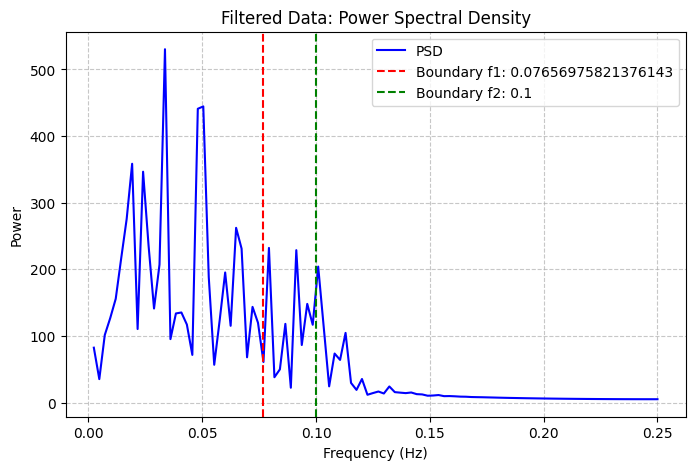

In [113]:
f2 = highcut

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata, label='PSD', linewidth=1.5, color='blue')

# Add dashed vertical lines at f1 and f2
plt.axvline(x=f1, color='red', linestyle='--', label=f'Boundary f1: {f1}')
plt.axvline(x=f2, color='green', linestyle='--', label=f'Boundary f2: {f2}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("Filtered Data: Power Spectral Density")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

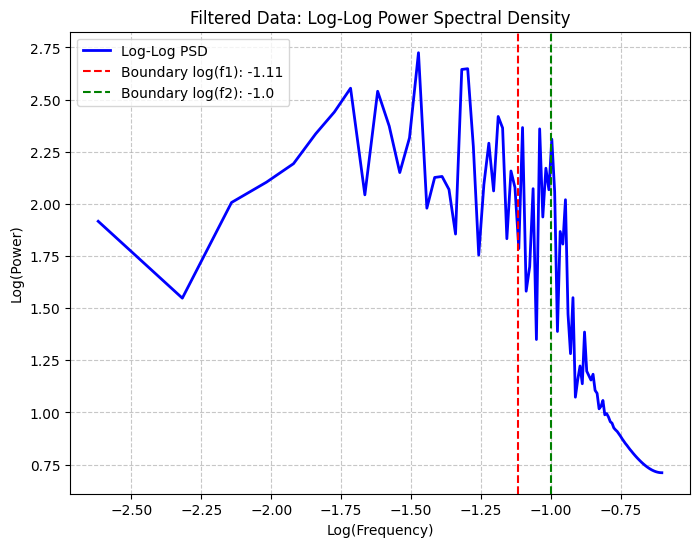

In [116]:
# Apply log transformation
log_xdata = np.log10(xdata)
log_ydata = np.log10(ydata)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(log_xdata, log_ydata, label="Log-Log PSD", linewidth=2, color='blue')

# Add dashed vertical lines at f1 and f2
plt.axvline(x=np.log10(f1), color='red', linestyle='--', label=f'Boundary log(f1): {np.ceil(np.log10(f1) * 100) / 100}')
plt.axvline(x=np.log10(f2), color='green', linestyle='--', label=f'Boundary log(f2): {np.ceil(np.log10(f2) * 100) / 100}')

# Add a dashed gray vertical line at frequencies 0.1 Hz and 0.15 Hz
# plt.axvline(x=np.log10(0.1), color='gray', linestyle='--')
# plt.axvline(x=np.log10(0.15), color='gray', linestyle='--')

plt.title("Filtered Data: Log-Log Power Spectral Density")
plt.xlabel("Log(Frequency)")
plt.ylabel("Log(Power)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [108]:
np.log10(highcut)

-1.0